<a href="https://colab.research.google.com/github/JonathanSum/Fastbook_colab/blob/master/02_production_Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://imgur.com/wniZTh0.jpg" width=300>

In [0]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   322  100   322    0     0   1076      0 --:--:-- --:--:-- --:--:--  1076
Updating fastai...
Done.


In [0]:
! git clone https://github.com/fastai/fastbook.git

Cloning into 'fastbook'...
remote: Enumerating objects: 283, done.
remote: Total 283 (delta 0), reused 0 (delta 0), pack-reused 283
Receiving objects: 100% (283/283), 40.06 MiB | 27.19 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [0]:
!pip install -r /content/fastbook/requirements.txt

     |████████████████████████████████| 184kB 4.8MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 92kB 9.6MB/s 
     |████████████████████████████████| 40kB 7.2MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 2.3MB 15.5MB/s 


In [0]:
!pip install -q feather-format kornia pyarrow wandb nbdev fastprogress fastai2 fastcore --upgrade 
!pip install torch==1.3.1
!pip install torchvision==0.4.2
!pip install Pillow==6.2.1 --upgrade

     |████████████████████████████████| 143kB 4.9MB/s 
     |████████████████████████████████| 63.2MB 49kB/s 
     |████████████████████████████████| 1.4MB 49.6MB/s 
     |████████████████████████████████| 102kB 15.8MB/s 
     |████████████████████████████████| 102kB 14.9MB/s 
     |████████████████████████████████| 102kB 15.1MB/s 
     |████████████████████████████████| 460kB 48.2MB/s 
     |████████████████████████████████| 71kB 11.5MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 
     |████████████████████████████████| 734.6MB 24kB/s 
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 1.3.1 which is incompatible.
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0


     |████████████████████████████████| 10.2MB 4.6MB/s 
ERROR: fastai2 0.0.11 has requirement torchvision>=0.5, but you'll have torchvision 0.4.2 which is incompatible.
  Found existing installation: torchvision 0.5.0
    Uninstalling torchvision-0.5.0:
      Successfully uninstalled torchvision-0.5.0


     |████████████████████████████████| 2.1MB 4.7MB/s 
ERROR: fastai2 0.0.11 has requirement torchvision>=0.5, but you'll have torchvision 0.4.2 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 6.2.2
    Uninstalling Pillow-6.2.2:
      Successfully uninstalled Pillow-6.2.2


In [0]:
from fastbook import utils

In [0]:
Path??

In [0]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

In [0]:
#hide
# from utils import *
from fastai2.vision.widgets import *

[[chapter_production]]

# From model to production

The five lines of code we've seen are just one small part of the process of using deep learning in practice. In this section, we're going to use a computer vision example to look at the end-to-end process of creating a deep learning application. More specifically: we're going to build a bear classifier! In the process, we'll discuss the capabilities and constraints of deep learning, learn about how to create datasets, look at possible gotchas when using deep learning in practice, and more.

## Picking a problem

We've seen that deep learning can solve a lot of challenging problems quickly and with little code. However, deep learning isn't magic! We often talk to people who overestimate both the constraints, and the capabilities of deep learning. Both of these can be problems: underestimating the capabilities means that you might not even try things which could be very beneficial; underestimating the constraints might mean that you fail to consider and react to important issues.

The best thing to do is to keep an open mind. If you remain open to the possibility that deep learning might solve part of your problem with less data or complexity than you expect, then it is possible to design a process where you can find the specific capabilities and constraints related to your particular problem as you work through the process. This doesn't mean making any risky bets — we will show you how you can gradually roll out models so that they don't create significant risks, and can even backtest them prior to putting them in production.

### The state of deep learning

In general, here is a summary of the state of deep learning is at the start of 2020. However, things move very fast, and by the time you read this some of these constraints may no longer exist. We will try to keep the book website up-to-date; in addition, a Google search for "what can AI do now" there is likely to provide some up-to-date information.

**Computer vision**: there are many domains in which deep learning has not been used to analyse images yet, but those where it has been tried have nearly universally shown that computers can recognise what items are in an image at least as well as people can — even specially trained people, such as radiologists. This is known as *object recognition*. Deep learning is also good at recognizing whereabouts objects in an image are, and can highlight their location and name each found object. This is known as *object detection* (there is also a variant of this we saw in <<chapter_intro>>, where every pixel is categorized based on what kind of object it is part of--this is called *segmentation*). Deep learning algorithms are generally not good at recognizing images that are significantly different in structure or style to those used to train the model. For instance, if there were no black-and-white images in the training data, the model may well do poorly on black-and-white images. If the training data did not contain hand-drawn images then the model will probably do poorly on hand-drawn images. There is no general way to check what types of image are missing in your training set, but we will show in this chapter some ways to try to recognize when unexpected image types arise in the data when the model is being used in production (this is known as checking for *out of domain* data).

One major challenge for object detection systems is that image labelling can be slow and expensive. There is a lot of work at the moment going into tools to try to make this labelling faster and more easy, and require less handcrafted labels to train accurate object detection models. One approach which is particularly helpful is to synthetically generate variations of input images, such as by rotating them, or changing their brightness and contrast; this is called *data augmentation* and also works well for text and other types of model. We will be discussing it in detail in this chapter.

Another point to consider is that although your problem might not look like a computer vision problem, it might be possible with a little imagination to turn it into one. For instance, if what you are trying to classify is sounds, you might try converting the sounds into images of their acoustic waveforms and then training a model on those images.

**Text (natural language processing)**: just like in computer vision, computers are very good at categorising both short and long documents based on categories such as spam, sentiment, author, source website, and so forth. We are not aware of any rigourous work done in this area to compare to human performance, but anecdotally it seems to us that deep learning performance is similar to human performance here. Deep learning is also very good at generating context-appropriate text, such as generating replies to social media posts, and imitating a particular author's style. It is also good at making this content compelling to humans, and has been shown to be even more compelling than human-generated text. However, deep learning is currently not good at generating *correct* responses! We don't currently have a reliable way to, for instance, combine a knowledge base of medical information, along with a deep learning model for generating medically correct natural language responses. This is very dangerous, because it is so easy to create content which appears to a layman to be compelling, but actually is entirely incorrect.

Another concern is that context-appropriate, highly compelling responses on social media can be used at massive scale — thousands of times greater than any troll farm previously seen — to spread disinformation, create unrest, and encourage conflict. As a rule of thumb, text generation will always be technologically a bit ahead of the ability of models to recognize automatically generated text. For instance, as we will see in this book, it is possible to use a model that can recognize artificially generated content to actually improve the generator that creates that content, until the classification model is no longer able to complete its task.

Despite these issues, deep learning can be used to translate text from one language to another, summarize long documents into something which can be digested more quickly, find all mentions of a concept of interest, and so forth. Unfortunately, the translation or summary could well include completely incorrect information! However, it is already good enough that many people are using the systems — for instance Google's online translation system (and every other online service we are aware of) is based on deep learning.

**Combining text and images**: the ability of deep learning to combine text and images into a single model is, generally, far better than most people intuitively expect. For example, a deep learning model can be trained on input images, and output captions written in English, and can learn to generate surprisingly appropriate captions automatically for new images! But again, we have the same warning that we discussed in the previous section: there is no guarantee that these captions will actually be correct.

Because of this serious issue we generally recommend that deep learning be used not as a entirely automated process, but as part of a process in which the model and a human user interact closely. This can potentially make humans orders of magnitude more productive than they would be with entirely manual methods, and actually result in more accurate processes than using a human alone. For instance, an automatic system can be used to identify potential strokes directly from CT scans, send a high priority alert to have potential/scans looked at quickly. There is only a three-hour window to treat strokes, so this fast feedback loop could save lives. At the same time, however, all scans could continue to be sent to radiologists in the usual way, so there would be no reduction in human input. Other deep learning models could automatically measure items seen on the scan, and insert those measurements into report, warn the radiologist about findings that they may have missed, and tell the radiologist about other cases which might be relevant.

**Tabular**: for analysing timeseries and tabular data, deep learning has recently been making great strides. However, deep learning is generally used as part of a ensemble of multiple types of model. If you already have a system that is using random forests or gradient boosting machines (popular tabular modelling tools that we will learn about soon) then switching to, or adding, deep learning may not result in any dramatic improvement. Deep learning does greatly increase the variety of columns that you can include, for example columns containing natural language (e.g. book titles, reviews, etc), and *high cardinality categorical* columns (i.e. something that contains a large number of discrete choices, such as zip code or product id). On the downside, deep learning models generally take longer to train than random forests or gradient boosting machines, although this is changing thanks to libraries such as [RAPIDS](https://rapids.ai/), which provides GPU acceleration for the whole modeling pipeline. We cover the pros and cons of all these methods in detail in <<chapter_tabular>> in this book.

**Recommendation systems**: Recommendation systems are really just a special type of tabular data. In particular, they generally have a high cardinality categorical variable representing users, and another one representing products (or something similar). A company like Amazon represents every purchase that has ever been made as a giant sparse matrix, with customers as the rows and products as the columns. Once they have the data in this format, data scientists apply some form of collaborative filtering to *fill in the matrix*. For example, if customer A buys products 1 and 10, and customer B buys products 1, 2, 4, and 10, the engine will recommend that A buy 2 and 4. Because deep learning models are good at handling high cardinality categorical variables they are quite good at handling recommendation systems. They particularly come into their own, just like for tabular data, when combining these variables with other kinds of data, such as natural language, or images. They can also do a good job of combining all of these types of information additional meta data represented as tables, such as user information, previous transactions, and so forth.

However, nearly all machine learning approaches have the downside that the only tell you what products a particular user might like, rather than what recommendations would be helpful for a user. Many kinds of recommendations for products a user might like may not be at all helpful, for instance, if the user is already familiar with its products, or if they are simply different packagings of products they have already purchased (such as a boxed set of novels, where they already have each of the items in that set). Jeremy likes reading books by Terry Pratchett, and for a while Amazon was recommending nothing but Terry Pratchett books to him, which really wasn't helpful because he already was aware of these books!

<img alt="Terry Pratchett books recommendation" caption="A not-so-useful recommendation" id="pratchett" src="https://github.com/fastai/fastbook/blob/master/images/pratchett.png?raw=1">

**Other data types**: Often you will find that domain-specific data types fit very nicely into existing categories. For instance, protein chains look a lot like natural language documents, in that they are long sequences of discrete tokens with complex relationships and meaning throughout the sequence. And indeed, it does turn out the using NLP deep learning methods is the current state of the art approach for many types of protein analysis. As another example: sounds can be represented as spectrograms, which can be treated as images; standard deep learning approaches for images turn out to work really well on spectrograms.

### The Drivetrain approach

There are many accurate models that are of no use to anyone, and many inaccurate models that are highly useful. To ensure that your modeling work is useful in practice, you need to consider how your work will be used. In 2012 Jeremy, along with Margit Zwemer and Mike Loukides, introduced a method called *The Drivetrain Approach* for thinking about this issue, which we will summarize here. For more information, see the full article on oreilly.com [Designing Great Data Products](https://www.oreilly.com/radar/drivetrain-approach-data-products/).

Consider a model in an autonomous vehicle, you want to help a car drive safely from point A to point B without human intervention. Great predictive modeling is an important part of the solution, but it doesn't stand on its own; as products become more sophisticated, it disappears into the plumbing. Someone using a self-driving car is completely unaware of the hundreds (if not thousands) of models and the petabytes of data that make it work. But as data scientists build increasingly sophisticated products, they need a systematic design approach.

We use data not just to generate more data (in the form of predictions), but to produce *actionable outcomes*. That is the goal of the Drivetrain Approach. Start by defining a clear **objective**. For instance, Google, when creating their first search engine, considered "What is the user’s main objective in typing in a search query?", and their answer was "show the most relevant search result". The next step is to consider what **levers** you can pull (i.e. what actions could you take) to better achieve that objective. In Google's case, that was the ranking of the search results. The third step was to consider what new **data** they would need to produce such a ranking; they realized that the implicit information regarding which pages linked to which other pages could be used for this purpose. Only after these first three steps do we begin thinking about building the predictive **models**. Our objective and available levers, what data we already have and what additional data we will need to collect, determine the models we can build. The models will take both the levers and any uncontrollable variables as their inputs; the outputs from the models can be combined to predict the final state for our objective.

<img src="https://github.com/fastai/fastbook/blob/master/images/drivetrain-approach.png?raw=1" id="drivetrain" caption="The Drivetrain approach">

Let's consider another example: recommendation systems. The **objective** of a recommendation engine is to drive additional sales by surprising and delighting the customer with recommendations of items they would not have purchased without the recommendation. The **lever** is the ranking of the recommendations. New **data** must be collected to generate recommendations that will *cause new sales*. This will require conducting many randomized experiments in order to collect data about a wide range of recommendations for a wide range of customers. This is a step that few organizations take; but without it, you don't have the information you need to actually optimize recommendations based on your true objective (more sales!)

Finally, you could build two **models** for purchase probabilities, conditional on seeing or not seeing a recommendation. The difference between these two probabilities is a utility function for a given recommendation to a customer. It will be low in cases where the algorithm recommends a familiar book that the customer has already rejected (both components are small) or a book that he or she would have bought even without the recommendation (both components are large and cancel each other out).

As you can see, in practice often the practical implementation of your model will require a lot more than just training a model! You'll often need to run experiments to collect more data, and consider how to incorporate your models into the overall system you're developing.

### Starting your project

So where should you start your deep learning journey? The most important thing is to ensure that you have some project that you are working on — it is only through working on your own projects that you will get real experience of building and using models. When selecting a project, the most important consideration is data availability. Regardless of whether you are doing a project just for your own learning, or for practical application in your organization, you want something where you can get started quickly. We have seen many students, researchers, and industry practitioners waste months or years while they attempt to find their perfect dataset. The goal is not to find the perfect dataset, or the perfect project, but just to get started, and iterate from there.

If you take this approach, then you will be on your third iteration of learning and improving whilst the perfectionists are still in the planning stages!

We also suggest that you iterate from end to end in your project; that is, don't spend months fine tuning your model, or polishing the perfect GUI, or labelling the perfect dataset… Instead, complete every step as well as you can in a reasonable amount of time, all the way to the end. For instance, if your final goal is an application that runs on a mobile phone, then that should be what you have after each iteration. But perhaps in the early iterations you take some shortcuts, for instance by doing all of the processing on a remote server, and using a simple responsive web application. By completing the project and to end, you will see where the most tricky bits are, and which bits make the biggest difference to the final result.

As you work through this book, we suggest that you both complete lots of small experiments, by running and adjusting the notebooks we provide, at the same time that you gradually develop your own projects. That way, you will be getting experience with all of the tools and techniques that were explaining, as we discuss them.

> s: To make the most of this book, take the time to experiment between each chapter, be it on your own project or exploring the notebooks we provide. Then try re-writing those notebooks from scratch on a new dataset. It's only by practicing (and failing) a lot that you will get an intuition on how to train a model.  

By using the end to end iteration approach you will also get a better understanding of how much data you really need. For instance, you may find you can only easily get 200 labelled data items, and you can't really know until you try whether that's enough to get the performance you need for your application to work well in practice.

In an organizational context you will be able to show your colleagues that your idea can really work, by showing them a real working prototype. We have repeatedly observed that this is the secret to getting good organizational buy in for a project.

Since it is easiest to get started on a project where you already have data available, that means it's probably easiest to get started on a project related to something you are already doing, because you already have data about things that you are doing. For instance, if you work in the music business, you may have access to many recordings. If you work as a radiologist, you probably have access to lots of medical images. If you are interested in wildlife preservation, you may have access to lots of images of wildlife.

Sometimes, you have to get a bit creative. Maybe you can find some previous machine learning project, such as a Kaggle competition, that is related to your field of interest. Sometimes, you have to compromize. Maybe you can't find the exact data you need for the precise project you have in mind; but you might be able to find something from a similar domain, or measured in a different way, tackling a slightly different problem. Working on these kinds of similar projects will still give you a good understanding of the overall process, and may help you identify other shortcuts, data sources, and so forth.

Especially when you are just starting out with deep learning it's not a good idea to branch out into very different areas to places that deep learning has not been applied to before. That's because if your model does not work at first, you will not know whether it is because you have made a mistake, or if the very problem you are trying to solve is simply not solvable with deep learning. And you won't know where to look to get help. Therefore, it is best at first to start with something where you can find an example online of somebody who has had good results with something that is at least somewhat similar to what you are trying to achieve, or where you can convert your data into a format similar what someone else has used before (such as creating an image from your data). Have a look at the *state of deep learning* earlier in this chapter for a reminder of what kinds of things deep learning is good at right now.

## Gathering data

For many types of projects, you may be able to find all the data you need online. The project we'll be completing in this chapter is a *bear detector*. It will discriminate between three types of bear: grizzly, black, and teddy bear. There are many images on the internet of each type of bear we can use. We just need a way to find them and download them. We've provided a tool you can use for this purpose, so you can follow along with this chapter, creating your own image recognition application for whatever kinds of object you're interested in. In the fast.ai course, thousands of students have presented their work on the course forums, displaying everything from Trinidad hummingbird varieties, to Panama bus types, and even an application that helped one student let his fiancee recognize his sixteen cousins during Christmas vacation!

To download images, you should sign up at Microsoft for *Bing Image Search*. You will be given a key, which you can either paste over `os.environ('AZURE_SEARCH_KEY')` below, or you can set in your terminal as:

    export AZURE_SEARCH_KEY=your_key_here

In [0]:
key = os.environ['AZURE_SEARCH_KEY']

As at the time of writing, Bing Image Search is the best option we know of for finding and downloading images. It's free for up to 1000 queries per month, and each query can download up to 150 images. However, something better might have come along between when we wrote this and when you're reading the book, so be sure to check out [book.fast.ai](https://book.fast.ai) where we'll let you know our current recommendation.

In [0]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('content_url')
len(ims)

150

We've successfully downloaded the URLs of 150 grizzly bears (or, at least, images that Bing Image Search finds for that search term). Let's look at one:

In [0]:
#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp '/content/drive/My Drive/Happy Sugar Life/happy sugar life data.7z' '/content'

In [0]:
!mkdir '/content/data/happy sugar life'

mkdir: cannot create directory ‘/content/data/happy sugar life’: File exists


In [0]:
!7za e -y '/content/happy sugar life data.7z' -o'/content/data/happy sugar life'


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 605032703 bytes (578 MiB)

Extracting archive: /content/happy sugar life data.7z
--
Path = /content/happy sugar life data.7z
Type = 7z
Physical Size = 605032703
Headers Size = 15579
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      3% 67 - asahi/asahi (33).png                                8% 131 - aunt's clothes/auntc (10).png                                          9% 139 - aunt's clothes/auntc (18).png                                         17

In [0]:
!rm -r '/content/data/happy sugar life'

In [0]:
dest = '/content/data/happy sugar life/sato/sato (702).png'
# download_url(ims[0], dest)

In [0]:
!mv '/content/asahi' "/content/data/happy sugar life"
!mv '/content/aunt' "/content/data/happy sugar life"
!mv '/content/aunt\'s clothes' "/content/data/happy sugar life"
!mv '/content/daichi' "/content/data/happy sugar life"
!mv '/content/sato' "/content/data/happy sugar life"
!mv '/content/sato _clothes' "/content/data/happy sugar life"
!mv '/content/shio' "/content/data/happy sugar life"
!mv '/content/shouko' "/content/data/happy sugar life"
!mv '/content/store_owner' "/content/data/happy sugar life"
!mv '/content/summa' "/content/data/happy sugar life"
!mv '/content/taiyo' "/content/data/happy sugar life"
!mv '/content/yuna' "/content/data/happy sugar life"


/bin/bash: -c: line 0: unexpected EOF while looking for matching `''
/bin/bash: -c: line 1: syntax error: unexpected end of file


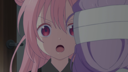

In [0]:
# im = Image.open(dest)
im =  Image.open(dest)
im.to_thumb(128,128)

In [0]:
!ls '/content/data/happy sugar life'

 asahi	 daichi  'sato _clothes'   shouko	 summa	 yuna
 aunt	 sato	  shio		   store_owner	 taiyo


This seems to have worked nicely, so let's use fastai's `download_images` to download all the URLs from each of our search terms. We'll put each in a separate folder.

In [0]:
happy_sugar_life_types = ['asahi','daichi','sato _clothes',
                          'shouko','summa', 'yuna','aunt', 'sato', 'shio', 'store_owner', 'taiyo']
# path = Path('bears')

In [0]:
path = Path('data/happy sugar life')

In [0]:
if not path.exists():
    path.mkdir()
    for o in happy_sugar_life_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} happy_sugar_life')
        # download_images(dest, urls=results.attrgot('content_url'))

Our folder has image files, as we'd expect:

In [0]:
fns = get_image_files(path)
len(fns)

1217

> j: I just love this about working in Jupyter notebooks! It's so easy to gradually build what I want, and check my work every step of the way. I make a *lot* of mistakes, so this is really helpful to me...

Often when we download files from the internet, there's a few that are corrupt. Let's check:

In [0]:
failed = verify_images(fns)
failed

(#0) []

### Sidebar: Getting help in jupyter notebooks

Jupyter notebooks are great to easily experiment and immediately see the results of each function, but there is also a lot of functionality to help figure out how to use the functions you have or even directly look at their source code. For instance, if you type in a cell
```
??verify_images
```
a window will pop up with:
```
Signature: verify_images(fns)
Source:   
def verify_images(fns):
    "Find images in `fns` that can't be opened"
    return L(fns[i] for i,o in
             enumerate(parallel(verify_image, fns)) if not o)
File:      ~/git/fastai/fastai/vision/utils.py
Type:      function
```
It tells us what argument the function accepts (`fns`) then shows us the source code and the file it comes from. Looking at that source code, we can see it applies the function `verify_image` in parallel and only keep the ones for which the result of that function is `False`, which is consistent with the doc string: it finds the images in `fns` that can't be opened.

Here are the commands that are very useful in jupyter notebooks:

- at any point, if you don't remember the exact spelling of a function or argument name, you can press "tab" to get suggestions of auto-completion.
- when inside the parenthesis of a function, pressing "shift" and "tab" simultaneously will display a window with the signature of the function and a short documentation. Pressing it twice will expand the documentation and pressing it three times will open a full window with the same information at the bottom of your screen.
- in a cell, typing `?func_name` and executing will open a window with the signature of the function and a short documentation.
- in a cell, typing `??func_name` and executing will open a window with the signature of the function, a short documentation and the source code.
- if you are using the fasti library, we added a `doc` function for you, executing `doc(func_name)` in a cell will open a window with the signature of the function, a short documentation and links to the source code on GitHub and the full documentation of the funciton in the [documentation of the library](https://docs.fast.ai).
- unrelated to the documentation but still very useful to get help, at any point, if you get an error, type `%debug` in the next cell and execute to open the [python debugger](https://docs.python.org/3/library/pdb.html) that will let you inspect the content of every variable.

### End sidebar

To remove the failed images, we can use `unlink` on each. Note that, like most fastai functions that return a collection, `verify_images` returns an object of type `L`, which includes the `map` method. This calls the passed function on each element of the collection.

In [0]:
failed.map(Path.unlink);

One thing to be aware of in this process: as we discussed in <<chapter_intro>>, models can only reflect the data used to train them. And the world is full of biased data, which ends up reflected in, for example, Bing Image Search (which we used to create our dataset). For instance, let's say you were interested in creating an app which could help users figure out whether they had healthy skin, so you trained a model on the results of searches for (say) *healthy skin*. Here's the results you would get:

<img src="https://github.com/fastai/fastbook/blob/master/images/healthy_skin.gif?raw=1" width="600" caption="Data for a healthy skin detector?" id="healthy_skin">

So with this as your training data, you would end up not with a healthy skin detector, but a *young white woman touching her face* detector! Be sure to think carefully about the types of data that you might expect to see in practice in your application, and check carefully to ensure that all these types are reflected in your model's source data. (Thanks to Deb Raji, who came up with the *healthy skin* example. See her paper *Actionable Auditing: Investigating the Impact of Publicly Naming Biased Performance Results of Commercial AI Products* for more fascinating insights into model bias.)

## From data to DataLoaders

Now that we have downloaded and verified of the data that we want to use, we need to turn it into a `DataLoaders` object. `DataLoaders` is a thin class which just stores whatever `DataLoader` objects you pass to it, and makes them available as `train` and `valid` . Although it's a very simple class, it's very important in fastai: it provides the data for your model. The key functionality in `DataLoaders` is provided with just these 4 lines of code (it has some other minor functionality we'll skip over for now):

```python
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])
```

> jargon: DataLoaders: a fastai class which stores whatever `DataLoader` objects you pass to it, and makes them available as properties.

To turn our downloaded data into `DataLoaders` we need to tell fastai at least four things:

- what kinds of data we are working with ;
- how to get the list of items ;
- how to label these items ;
- how to create the validation set.

So far we have seen a number of *factory methods* for particular combinations of these things, which are convenient when you have an application and data structure which happens to fit into those predefined methods. For when you don't, fastai has an extremely flexible system called the *data block API*. With this API you can fully customize every stage of the creation of your DataLoaders. Here is what we need to create a DataLoaders for the dataset that we just downloaded:

In [0]:
happy_sugar_life = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

Let's look at each of these sections in turn:

```python
blocks=(ImageBlock, CategoryBlock)
```

This is a tuple where we specify what types we want for the *independent* and *dependent* variables. The *independent variable* is the thing we are using to make predictions from, and the *dependent variable* is our target. In this case, our independent variable is a set of images, and our dependent variable are the categories (type of bear) for each image. We will see many other types of block in the rest of this book.

```python
get_items=get_image_files
```

For this DataLoaders our underlying items will be file paths. We have to tell fastai how to get a list of those files. The `get_image_files` function takes a path, and returns a list of all of the images in that path (recursively, by default).

```python
splitter=RandomSplitter(valid_pct=0.2, seed=42)
```

Often, datasets that you download will already have a validation set defined. Sometimes this is done by placing the images for the training and validation sets into different folders. Sometimes it is done by providing a CSV in which each file name is listed along with which dataset it should be in. There are many ways that this can be done, and fastai provides a very general approach which allows you to use one of fastai's predefined classes for this, or to write your own. In this case, however, we simply want to split our training and validation sets randomly. However, we would like to have the same training/validation split each time we run this notebook, so we fix the random seed. (Computers don't really know how to create random numbers at all, but simply create lists of numbers which look random. If you provide the same starting point for that list each time — called the *seed* — then you will get the exact same list each time.)

```python
get_y=parent_label
```

The independent variable is often referred to as "x" and the dependent variable is often referred to as "y". So in this section we are telling fastai what function to call to create the labels in our dataset. `parent_label` is a function provided by fastai which simply gets the name of the folder which a file is in. Because we put each of our bear images into folders based on the type of bear, this is going to give us the labels that we need.

```python
item_tfms=Resize(128)
```

Our images are all different sizes, and this is a problem for deep learning: we don't feed the model one image at a time but several (what we call a *mini-batch*) of them. To group them in a big array (usually called *tensor*) that is going to go through our model, they all need to be of the same size. So we need to add a transform twhich will resize these images to the same size. *item transforms* are pieces of code which run on each individual item, whether it be an image, category, or so forth. fastai includes many predefined transforms; we will use the `Resize` transform here.

This command has given us a `DataBlock` object. This is like a *template* for creating a `DataLoaders`. We still need to tell fastai the actual source of our data — in this case, the path where the images can be found.

In [0]:
dls = happy_sugar_life.dataloaders(path)

A DataLoaders includes validation and training `DataLoader`s. A `DataLoader` is a class which provides *batches* of a few items at a time to the GPU. We'll be learning a lot more about this class in the next chapter. When you loop through a `DataLoader` fastai will give you 64 (by default) items at a time, all stacked up into a single tensor. We can take a look at a few of those items by calling the `show_batch` method on a `DataLoader`:

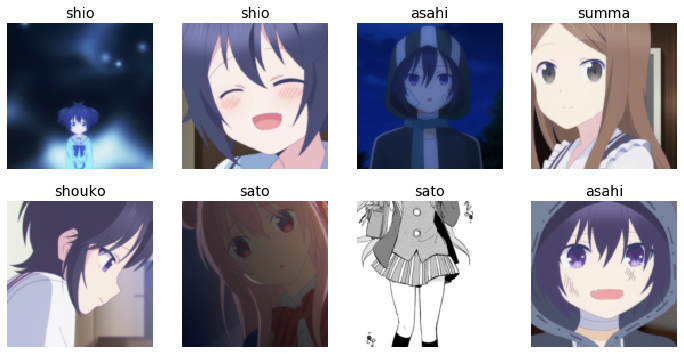

In [0]:
dls.valid.show_batch(max_n=8, rows=2)

By default `Resize` *crops* the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details. Alternatively, you can ask fastai to pad the images with zeros (which is black), or squish/stretch them:

This part is right because the image sometimes became clothes only for person.

In [0]:
!rm '/content/data/happy sugar life/sato/sato (516).png'

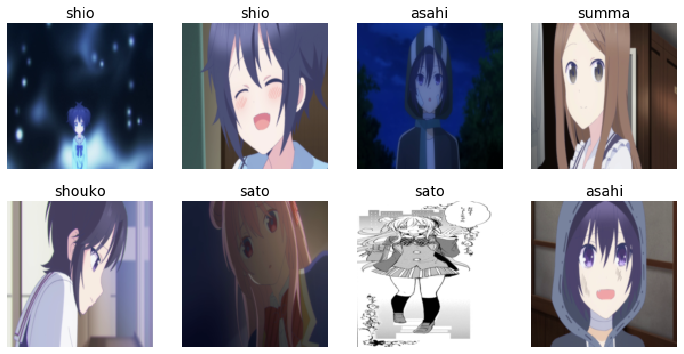

In [0]:
happy_sugar_life = happy_sugar_life.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = happy_sugar_life.dataloaders(path)
dls.valid.show_batch(max_n=8, rows=2)

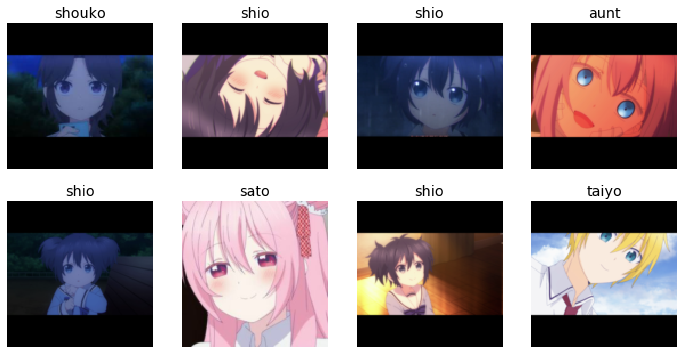

In [0]:
happy_sugar_life = happy_sugar_life.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = happy_sugar_life.dataloaders(path)
dls.valid.show_batch(max_n=8, rows=2)

## Data augmentation

All of these approaches seem somewhat wasteful, or problematic. If we squished or stretch the images then the end up unrealistic shapes, leading to a model that learns that things look different to how they actually are, which we would expect to result in lower accuracy. If we crop the images then we remove some of the features that allow us to recognize them. For instance, if we were trying to recognise the breed of dog or cat, we may end up cropping out a key part of the body or the face necessary to distinguish between similar breeds. If we pat the images then we have a whole lot of empty space, which is just wasted computation for our model, and results in a lower effective resolution for the part of the image we actually use.

Instead, what we normally do in practice is to randomly select part of the image, and crop to just that part. On each epoch (which is one complete pass through all of our images in the dataset) we randomly select a different part of each image. This means that our model can learn to focus on, and recognize, different features in our images. It also reflects how images work in the real world; different photos of the same thing may be framed in slightly different ways.

Here is a another copy of the previous examples, but this time we are replacing `Resize` with `RandomResizedCrop`, which is the transform that provides the behaviour described above.The most important parameter to pass in is the `min_scale` parameter, which determines how much of the image to select at minimum each time.

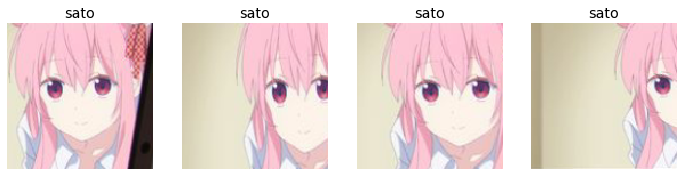

In [0]:
happy_sugar_life = happy_sugar_life.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = happy_sugar_life.dataloaders(path)
dls.train.get_idxs = lambda: Inf.ones
dls.train.show_batch(max_n=4, rows=1)

> note: The second line in this code is a little bit magic, and you absolutely don't have to understand it at this point. So feel free to ignore the entirety of this paragraph! This is for just if you're curious… Showing different randomly varied versions of the same image is not something we normally have to do in deep learning, so it's not something that fastai provides directly. Therefore to draw the picture of data augmentation on the same image, we had to take advantage of fastai's sophisticated customisation features. DataLoader has a method called `get_idx`, which is called to decide which items should be selected next. Normally when we are training, this returns a random permutation of all of the indexes in the dataset. But pretty much everything in fastai can be changed, including how the `get_idx` method is defined, which means we can change how we sample data. So in this case, we are replacing it with a version which always returns the number one. That way, our DataLoader shows the same image again and again! This is a great example of the flexibility that fastai provides. 

In fact, an entirely untrained neural network knows nothing whatsoever about how images behave. It doesn't even recognise that when an object is moved one pixel to the left, then it still is a picture of the same thing! So actually training the neural network with examples of images that are in slightly different places, and slightly different sizes, helps it to understand the basic concept of what a *object* is, and how it can be represented in an image.

This is a specific example of a more general technique, called *data augmentation*. Data augmentation refers to creating random variations of our input data, such that they appear a different, but are not expected to change the meaning of the data. Examples of common data augmentation for images are rotation, flipping, perspective warping, brightness changes, contrast changes, and much more. For natural photo images such as the ones we are using here, there is a standard set of augmentations which we have found work pretty well, and are provided with the get transforms function. Because the images are now all the same size, we can apply these augmentation is to an entire batch of the time using the GPU, which will save a lot of time. To tell fastai we want to use these transforms to a batch, we use the `batch_tfms` parameter. (Note that's we're not using `RandomResizedCrop` in this example, so you can see the differences more clearly; we're also using double the amount of augmentation compared to the default, for the same reason).

In [0]:
happy_sugar_life = happy_sugar_life.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = happy_sugar_life.dataloaders(path)
dls.train.get_idxs = lambda: Inf.ones
dls.train.show_batch(max_n=8, rows=2)

## Training your model, and using it to clean your data

We'll use `RandomResizedCrop` and default `aug_transforms` for our model, and an image size of 224px, which is fairly standard for image classification.

In [0]:
happy_sugar_life = happy_sugar_life.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = happy_sugar_life.dataloaders(path)

We can now create our `Learner` and fine tune it in the usual way.

In [0]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,2.986974,1.068518,0.279452,00:29


epoch,train_loss,valid_loss,error_rate,time
0,1.172152,0.575630,0.134247,00:30
1,0.800773,0.486169,0.123288,00:30
2,0.600269,0.371099,0.106849,00:30
3,0.468375,0.332204,0.093151,00:30


Now let's see whether the mistakes the model is making is mainly thinking that grizzlies are teddies (that would be bad for safety!), or that grizzlies are black bears, or something else. We can create a *confusion matrix*:

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()                     #resnet34

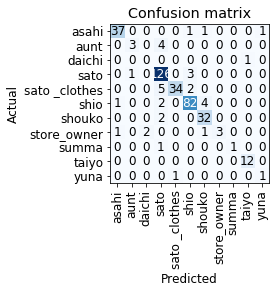

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Each row here represents all the black, grizzly, and teddy bears in our dataset, respectively. Each column represents the images which the model predicted as black, grizzly, and teddy bears, respectively. Therefore, the diagonal of the matrix shows the images which were classified correctly, and the other, off diagonal, cells represent those which were classified incorrectly. This is called a *confusion matrix* and is one of the many ways that fastai allows you to view the results of your model. It is (of course!) calculated using the validation set. With the color coding, the goal is to have white everywhere, except the diagonal where we want dark blue. Our bear classifier isn't making many mistakes!

It's helpful to see where exactly our errors are occuring, to see whether it's due to a dataset problem (e.g. images that aren't bears at all, or are labelled incorrectly, etc), or a model problem (e.g. perhaps it isn't handling images taken with unusual lighting, or from a different angle, etc.) To do this, we can sort out images by their *loss*. The *loss* is a number that is higher if the model is incorrect (and especially if it's also confident of its incorrect answer), or if it's correct, but not confident of its correct answer. (We'll learn how loss is calculated later in the book.) `plot_top_losses` shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four things: prediction, actual (target label), loss, and probability. The *probability* here is the confidence level, from zero to one, that the model has assigned to its prediction.

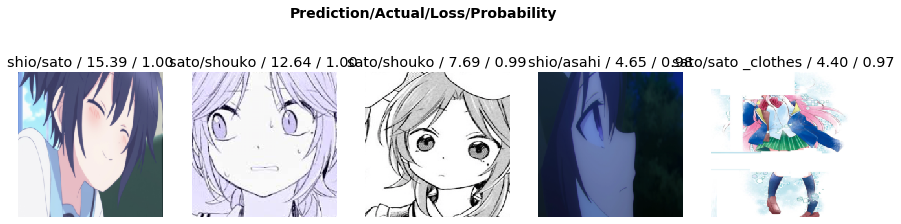

In [0]:
interp.plot_top_losses(5, rows=1)

In [0]:
learn.save("02v2_char_ind")

In [0]:
learn.export()

In [0]:
!cp '/content/models/02v2_char_ind.pth' '/content/drive/My Drive/fastai-v3'
!cp '/content/export.pkl' '/content/drive/My Drive/fastai-v3'

This output shows that the highest loss is an image that has been predicted as "grizzly" with high confidence. However, it's labeled (based on our Bing image search) as "black". We're not bear experts, but it sure looks to us like this label is incorrect! We should probably change its label to "grizzly".

The intuitive approach to doing data cleaning is to do it *before* you train a model. But as you've seen in this case, a model can actually help you find data issues more quickly and easily. So we normally prefer to train a quick and simple model first, and then use it to help us with data cleaning.

fastai includes a handy GUI for data cleaning called `ImageClassifierCleaner`, which allows you to choose a category, and training vs validation set, and view the highest-loss images (in order), along with menus to allow any images to be selected for removal, or relabeling.

In [0]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

<img alt="Cleaner widget" width="700" caption="Cleaner widget" id="cleaner" src="https://github.com/fastai/fastbook/blob/master/images/att_00007.png?raw=1">

We can see that amongst our *black bears* is an image that contain two bears, one grizzly, one black. So we should choose `<Delete>` in the menu under this image. `ImageClassifierCleaner` doesn't actually do the deleting or changing of labels for you; it just returns the indices of items to change. So, for instance, to delete (`unlink`) all images selected for deletion, we would run:

```python
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
```

To move images where we've selected a different category, we would run:

```python
for idx,cat in cleaner.change(): shutil.move(cleaner.fns[idx], path/cat)
```

> s: Cleaning the data or getting it ready for your model are two of the biggest challenges for data scientists, one they say take 90% of their time. The fastai library aims at providing tools to make it as easy as possible.

We'll be seeing more examples of model-driven data cleaning throughout this book. Once we've cleaned up our data, we can retrain our model. Try it yourself, and see if your accuracy improves!

> note: After cleaning the dataset using the above steps, we generally are seeing 100% accuracy on this task. We even see that result when we download a lot less images than the 150 per class we're using here. As you can see, the common complaint *you need massive amounts of data to do deep learning* can be a very long way from the truth!

## Turning your model into an online application

### Using the model for inference

We are now going to look at what it takes to take this model and turn it into a working online application. We will just go as far as creating a basic working prototype; we do not have the scope in this book to teach you all the details of web application development generally.

Once you've got a model you're happy with, you need to save it, so that you can then copy it over to a server where you'll use it in production. Do you remember exactly what a model is? It consists of two parts: the *architecture*, and the trained *parameters*. The easiest way to save a model is to save both of these, because that way when you load a model you can be sure that you have the matching architecture and parameters. To save both parts, use the `export` method.

This method even saves the definition of how to create your `DataLoaders`. This is important, because otherwise you would have to redefine how to transform your data in order to use your model in production. When you call export, fastai will save a file called `export.pkl`.

In [0]:
learn.export()

Let's check that file exists:

In [0]:
path = Path()
Path().ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

You'll need this file wherever you deploy your app to. For now, let's try to create a simple app within our notebook.

When we use a model for getting predictions, instead of training, we call it *inference*. To create our inference learner from the exported file, we use `load_learner` (in this case, this isn't really necessary, since we already have a working `Learner` in our notebook; we're just doing it here so you can see the whole process end-to-end):

In [0]:
learn_inf = load_learner(path/'export.pkl')

When we're doing inference, we're generally just getting predicitions for one image at a time. To do this, pass a filename to `predict`:

In [0]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([9.0767e-06, 9.9999e-01, 1.5748e-07]))

This has returned three things: the predicted category in the same format you originally provided, in this case that's a string), the index of the predicted category, and the probabilities of each category. The last two are based on the order of categories in the *vocab* of the `DataLoaders`; that is, the stored list of all possible categories. At inference time, you can access the `DataLoaders` as an attribute of the `Learner`:

In [0]:
learn_inf.dls.vocab

(#3) ['black','grizzly','teddy']

We can see here that if we index into the vocab with the integer returned by `predict` then we get back "grizzly", as expected. Also, note that if we index into the list of probabilities, we see a nearly 1.00 probability that this is a grizzly.

### Creating a Notebook app from the model

To use our model in an application we can simply treat the `predict` method as a regular function. Therefore, creating an app from the model can be done using any of the myriad of frameworks and techniques available to application developers.

However, most data scientists are not familiar with the world of web application development. So let's try using something that you do, at this point, know: Jupyter notebooks. It turns out that we can create a complete working web application using nothing but Jupyter notebooks! The two things we need to make this happen are:

- IPython widgets (ipywidgets)
- Voilà

*IPython widgets* are GUI components that bring together JavaScript and Python functionality in a web browser, and can be created and used within a Jupyter notebook. For instance, the image cleaner that we saw earlier in this chapter is entirely written with IPython widgets. However, we don't want to require users of our application to have to run Jupyter themselves.

That is why *Voilà* exists. It is a system for making applications consisting of IPython widgets available to end-users, without them having to use Jupyter at all. Voila is taking advantage of the fact that a notebook _already is_ a kind of web application, just a rather complex one that depends on another web application Jupyter itself. Essentially, it helps us automatically convert the complex web application which we've already implicitly made (the notebook) into a simpler, easier-to-deploy web application, which functions like a normal web application rather than like a notebook.

But we still have the advantage of developing in a notebook. So with ipywidgets, we can build up our GUI step by step. We will use this approach to create a simple image classifier. First, we need a file upload widget:

In [0]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

<img alt="An upload button" width="159" src="https://github.com/fastai/fastbook/blob/master/images/att_00008.png?raw=1">

Now we can grab the image:

In [0]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [0]:
img = PILImage.create(btn_upload.data[-1])

<img alt="Output widget representing the image" width="117" src="https://github.com/fastai/fastbook/blob/master/images/att_00009.png?raw=1">

We can use an `Output` widget to display it:

In [0]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

<img alt="Output widget representing the image" width="117" src="https://github.com/fastai/fastbook/blob/master/images/att_00009.png?raw=1">

Then we can get our predictions:

In [0]:
pred,pred_idx,probs = learn_inf.predict(img)

...and use a `Label` to display them:

In [0]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

`Prediction: grizzly; Probability: 1.0000`

We'll need a button to do the classification, it looks exactly like the upload button.

In [0]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

...and a *click event handler*, that is, a function that will be called when it's pressed; we can just copy over the lines of code from above:

In [0]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

You can test the button now by pressing it, and you should see the image and predictions above update automatically!

We can now put them all in a vertical box (`VBox`) to complete our GUI:

In [0]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [0]:
#hide_output
VBox([widgets.Label('Select your bear!'), btn_upload, btn_run, out_pl, lbl_pred])

<img alt="The whole widget" width="233" src="https://github.com/fastai/fastbook/blob/master/images/att_00011.png?raw=1">

### Turning your notebook into a real app

Now that we have everything working in this Jupyter notebook, we can create our application. To do this, create a notebook which contains only the code needed to create and show the widgets that you need, and markdown for any text that you want to appear. Have a look at the *bear_classifier* notebook in the book repo to see the simple notebook application we created.

Next, install Voila if you have not already, by copying these lines into a Notebook cell, and executing it:

    !pip install voila
    !jupyter serverextension enable voila --sys-prefix

Cells which begin with a `!` do not contain Python code, but instead contain code which is passed to your shell, such as bash, power shell in windows, or so forth. If you are comfortable using the command line (which we'll be learning about later in this book), you can of course simply type these two lines (without the `!` prefix) directly into your terminal. In this case, the first line installs the voila library and application, and the second connects it to your existing Jupyter notebook.

Voila runs Jupyter notebooks, just like the Jupyter notebook server you are using now does, except that it does something very important: it removes all of the cell inputs, and only shows output (including ipywidgets), along with your markdown cells. So what's left is a web application! To view your notebook as a voila web application replace the word "notebooks" in your browser's URL with: "voila/render". You will see the same content as your notebook, but without any of the code cells.

Of course, you don't need to use Voila or ipywidgets. Your model is just a function you can call: `pred,pred_idx,probs = learn.predict(img)` . So you can use it with any framework, hosted on any platform. And you can take something you've prototyped in ipywidgets and Voila and later convert it into a regular web application. We're showing you this approach in the book because we think it's a great way for data scientists and other folks that aren't web development experts to create applications from their models.

### Deploying your app

As we now know, you need a GPU to train nearly any useful deep learning model. So, do you need a GPU to use that model in production? No! You almost certainly **do not need a GPU to serve your model in production**. There's a few reasons for this:

- As we've seen, GPUs are only useful when they do lots of identical work in parallel. If you're doing (say) image classification, then you'll normally be classifying just one user's image at a time, and there isn't normally enough work to do in a single image to keep a GPU busy for long enough for it to be very efficient. So a CPU will often be more cost effective.
- An alternative could be to wait for a few users to submit their images, and then batch them up, and do them all at once on a GPU. But then you're asking your users to wait, rather than getting answers straight away! And you need a high volume site for this to be workable.
- The complexities of dealing with GPU inference are significant. In particular, the GPU's memory will need careful manual management, and you'll need some careful queueing system to ensure you only do one batch at a time
- There's a lot more market competition in CPU servers than GPU, as a result of which there's much cheaper options available for CPU servers.

Because of the complexity of GPU serving, many systems have sprung up to try to automate this. However, managing and running these systems is themselves complex, and generally requires compiling your model into a different form that's specialized for that system. It doesn't make sense to deal with this complexity until/unless your app gets popular enough that it makes clear financial sense for you to do so.

For at least the initial prototype of your application, and for any hobby projects that you want to show off, you can easily host them for free. The best place and the best way to do this will vary over time so check the book website for the most up-to-date recommendations. As we're writing this book in 2020 the simplest (and free!) approach is called [Binder](https://mybinder.org/). To publish your web app on Binder, you follow these steps:

1. Add your notebook to a [GitHub repository](http://github.com/), 
2. Paste the URL of that repo in the URL field of Binder, 
3. Change the "File" dropdown to instead select "URL",
4. In the Path field, enter `/voila/render/name.ipynb` (replacing `name.ipynb` as appropriate for your notebook):
5. Click the "Copy the URL" button and paste it somewhere safe. 
6. Click "Launch".

<img alt="Deploying to Binder" width="800" caption="Deploying to Binder" id="deploy-binder" src="https://github.com/fastai/fastbook/blob/master/images/att_00001.png?raw=1">

The first time you do this Binder will take around 5 minutes to build your site. In other words, is it finding a virtual machine which can run your app, allocating storage, collecting the files needed for Jupyter, for your notebook, and for presenting your notebook as a web application. It's doing all of this behind the scenes.

Finally, once it has started the app running, it will navigate your browser to your new web app. You can share the URL you copied to allow others to access your app as well.

For other (both free and paid) options for deploying your web app, be sure to take a look at the book web site.

You may well want to deploy your application onto mobile devices, or edge devices such as a Raspberry Pi. There are a lot of libraries and frameworks to allow you to integrate a model directly into a mobile application. However these approaches tend to require a lot of extra steps and boilerplate, and do not always support all the PyTorch and fastai layers that your model might use. In addition, the work you do will depend on what kind of mobile devices you are targeting for deployment. So you might need to do some work to run on iOS devices, different work to run on newer Android devices, different work for older Android devices, etc.. Instead, we recommend wherever possible that you deploy the model itself to a server, and have your mobile or edge application connect to it as a web service.

There is quite a few upsides to this approach. The initial installation is easier, because you only have to deploy a small GUI application, which connects to the server to do all the heavy lifting. More importantly perhaps, upgrades of that core logic can happen on your server, rather than needing to be distributed to all of your users. Your server can have a lot more memory and processing capacity than most edge devices, and it is far easier to scale those resources if your model becomes more demanding. The hardware that you will have on a server is going to be more standard and more easily supported by fastai and PyTorch, so you don't have to compile your model into a different form.

There are downsides too, of course. Your application will require a network connection, and there will be some latency each time the model is called. It takes a while for a neural network model to run anyway, so this additional network latency may not make a big difference to your users in practice. In fact, since you can use better hardware on the server, the overall latency may even be less! If your application uses sensitive data then your users may be concerned about an approach which sends that data to a remote server, so sometimes privacy considerations will mean that you need to run the model on the edge device. Sometimes this can be avoided by having a *on premise* server, such as inside a company's firewall. Managing the complexity and scaling the server can create additional overhead, whereas if your model runs on the edge devices then each user is bringing their own compute resources, which leads to easier scaling with an increasing number of users (also known as _horizontal scaling_).

> A: I've had a chance to see up close how the mobile ML landscape is changing in my work. We offer an iPhone app that depends on computer vision and for years we ran our own computer vision models in the cloud. This was the only way to do it then since those models needed significant memory and compute resources and took minutes to process. This approach required building not only the models (fun!) but infrastructure to ensure a certain number of "compute worker machines" was absolutely always running (scary), that more machines would automatically come online if traffic increased, that there was stable storage for large inputs and outputs, that the iOS app could know and tell the user how their job was doing, etc... Nowadays, Apple provides APIs for converting models to run efficiently on device and most iOS devices have dedicated ML hardware, so we run our new models on device. So, in a few years that strategy has gone from impossible to possible but it's still not easy. In our case it's worth it, for a faster user experiene and to worry less about servers. What works for you will depend, realistically, on the user experience you're trying to create and what you personally find it easy to do. If you really know how to run servers, do it. If you really know how to build native mobile apps, do that. There are many roads up the hill.

Overall, we'd recommend using a simple CPU-based server approach where possible, for as long as you can get away with it. If you're lucky enough to have a very successful application, then you'll be able to justify the investment in more complex deployment approaches at that time.

## How to avoid disaster

In practice, a deep learning model will be just one piece of a much bigger system. As we discussed at the start of this chapter, a *data product* requires thinking about the entire end to end process within which or model lives.

One of the biggest issues with this is that understanding and testing the behavior of a deep learning model is much more difficult than most code that you would write. With normal software development you can analyse the exact steps that the software is taking, and carefully study with of these steps match the desired behaviour that you are trying to create. But with a neural network the behavior emerges from the models attempt to match the training data, rather than being exactly defined.

This can result in disaster! For instance, let's say you really were rolling out a bear detection system which will be attached to video cameras around the campsite, and will warn campers of incoming bears. If we used a model trained with the dataset we downloaded, there are going to be all kinds of problems in practice, such as:

- working with video data instead of images ;
- handling nighttime images, which may not appear in this dataset ;
- dealing with low resolution camera images ;
- ensuring results are returned fast enough to be useful in practice ;
- recognising bears in positions that are rarely seen in photos that people post online (for example from behind, partially covered by bushes, or when a long way away from the camera).

A big part of the issue is that the kinds of photos that people are most likely to upload to the Internet are the kinds of photos that do a good job of clearly and artistically displaying their subject matter. So we may need to do a lot of our own data collection and labelling to create a useful system.

This is just one example of the more general problem of *out of domain* data. That is to say, there may be data that our model sees in production which is very different to what it saw during training. There isn't really a complete technical solution to this problem; instead we have to be careful about our approach to rolling out the technology.

There are other reasons we need to be careful too. One very common problem is *domain shift*; this is where the type of data that our model sees changes over time. For instance, an insurance company may use a deep learning model as part of their pricing and risk algorithm, but over time the type of customers that they attract, and the type of risks that they represent, may change so much that the original training data is no longer relevant.

Out of domain data, and domain shift, are examples of the problem that you can never fully no the entire behaviour of your neural network. They have far too many parameters to be able to analytically understand all of their possible behaviours. This is the natural downside of the thing that they're so good at — their flexibility in being able to solve complex problems where we may not even be able to fully specify our preferred solution approaches. The good news, however, is that there are ways to mitigate these risks using a carefully thought out process. The details of this will vary depending on the details of the problem you are solving, but we will attempt to lay out here a high-level approach which we hope will provide useful guidance.

<img alt="Deployment process" width="500" caption="Deployment process" id="deploy_process" src="https://github.com/fastai/fastbook/blob/master/images/att_00061.png?raw=1">

Where possible, the first step is to use an entirely manual process, with your deep learning model approach running in parallel, but not being used directly to drive any actions. The humans involved in the manual process should look at the deep learning outputs and check whether they make sense. For instance, with our bear classifier a park ranger could have a screen displaying any time a possible bear sighting occurred in any camera, and simply highlight them in red on the screen. The park ranger would still be expected to be just as alert as before the model was deployed; they are simply helping to check for problems at this point.

The second step is to try to limit the scope of the model, and have it carefully supervised by people. For instance, do a small geographically and time constrained trial of the model-driven approach. Rather than rolling your bear classifier out in every national park throughout the country, pick a single observation post, for a one-week period, and have a park ranger check each alert before it goes out.

Then, gradually increase the scope of your rollout. As you do so, ensure that you have really good reporting systems in place, to make sure that you are aware of any significant changes to the actions being taken compared to your manual process. For instance, if the number of bear alerts doubles or halves after rollout of the new system in some location we should be very concerned. Try to think about all the ways in which your system could go wrong, and then think about what measure or report or picture could reflect that problem, and then ensure that your regular reporting includes that information.

> j: I started a company 20 years ago called *Optimal Decisions* which used machine learning and optimisation to help giant insurance companies set their pricing, impacting tens of billions of dollars of risks. We used the approaches described above to manage the potential downsides of something that might go wrong. Also, before we worked with our clients to put anything in production, we tried to simulate the impact by testing the end to end system on their previous year's data. It was always quite a nerve-wracking process, putting these new algorithms in production, but every rollout was successful.

### Unforeseen consequences and feedback loops

One of the biggest challenges in rolling out a model is that your model may change the behaviour of the system it is a part of. For instance, consider YouTube's recommendation system. A couple of years ago Google talked about how they had introduced reinforcement learning (closely related to deep learning, but where your loss function represents a result which could be a long time after an action occurs) to improve their recommendation system. They described how they used an algorithm which made recommendations such that watch time would be optimised.

However, human beings tend to be drawn towards controversial content. This meant that videos about wings like conspiracy theories started to get recommended more and more by the recommendation system. Furthermore, it turns out that the kinds of people that are interested in conspiracy theories are also people that watch a lot of online videos! So, they started to get drawn more and more towards YouTube. The increasing number of conspiracy theorists watching YouTube resulted in the algorithm recommending more and more conspiracy theories and other extremist content, which resulted in more extremists watching videos on YouTube, and more people watching YouTube developing extremist views, which led to the algorithm recommending more extremist content... The system became so out of control that in February 2019 it led the New York Times to run the headline "YouTube Unleashed a Conspiracy Theory Boom. Can It Be Contained?"

A helpful exercise prior to rolling out a significant machine learning system is to consider this question: "what would happen if it went really, really well?" In other words, what if the predictive power was extremely high, and its ability to influence behaviour was extremely significant? In that case, who would be most impacted? What would the most extreme results potentially look like? How would you know what was really going on?

Such a thought exercise might help you to construct a more careful rollout plan, ongoing monitoring systems, and human oversight. Of course, human oversight isn't useful if it isn't listened to; so make sure that there are reliable and resilient communication channels so that the right people will be aware of issues, and will have the power to fix them.

## Get writing!

One of the things our students have found most helpful to solidify their understanding of this material is to write it down. There is no better test of your understanding of a topic than attempting to teach it to somebody else. This is helpful even if you never show your writing to anybody — but it's even better if you share it! So we recommend that, if you haven't already, you start a blog. Now that you've finished chapter 2, and have learned how to train and deploy models, you're well placed to write your first blog post about your deep learning journey. What's surprised you? What opportunities do you see for deep learning in your field? What obstacles do you see?

Rachel Thomas, co-founder of fast.ai, wrote in the article [Why you (yes, you) should blog](https://medium.com/@racheltho/why-you-yes-you-should-blog-7d2544ac1045):

```asciidoc
____
The top advice I would give my younger self would be to start blogging sooner. Here are some reasons to blog:

* It’s like a resume, only better. I know of a few people who have had blog posts lead to job offers!
* Helps you learn. Organizing knowledge always helps me synthesize my own ideas. One of the tests of whether you understand something is whether you can explain it to someone else. A blog post is a great way to do that.
* I’ve gotten invitations to conferences and invitations to speak from my blog posts. I was invited to the TensorFlow Dev Summit (which was awesome!) for writing a blog post about how I don’t like TensorFlow.
* Meet new people. I’ve met several people who have responded to blog posts I wrote.
* Saves time. Any time you answer a question multiple times through email, you should turn it into a blog post, which makes it easier for you to share the next time someone asks.
____
```

Perhaps her most important tip is this: "*You are best positioned to help people one step behind you. The material is still fresh in your mind. Many experts have forgotten what it was like to be a beginner (or an intermediate) and have forgotten why the topic is hard to understand when you first hear it. The context of your particular background, your particular style, and your knowledge level will give a different twist to what you’re writing about*."

We've provided full details on how to set up a blog in an appendix "_Creating a blog_". If you don't have a blog already, jump over to that chapter now, because we've got a really great approach set up for you to start blogging, for free, with no ads--and you can even use Jupyter Notebook!

## Questionnaire

1. Provide an example of where the bear classification model might work poorly, due to structural or style differences to the training data
1. Where do text models currently have a major deficiency?
1. What are possible negative societal implications of text generation models?
1. In situations where a model might make mistakes, and those mistakes could be harmful, what is a good alternative to automating a process?
1. What kind of tabular data is deep learning particularly good at?
1. What's a key downside of directly using a deep learning model for recommendation systems?
1. What are the steps of the Drivetrain approach?
1. How do the steps of the Drivetrain approach map to a recommendation system?
1. Create an image recognition model using data you curate, and deploy it on the web.
1. What is `DataLoaders`?
1. What four things do we need to tell fastai to create `DataLoaders`?
1. What does the `splitter` parameter to `DataBlock` do?
1. How do we ensure a random split always gives the same validation set?
1. What letters are often used to signify the independent and dependent variables?
1. What's the difference between crop, pad, and squish resize approaches? When might you choose one over the other?
1. What is data augmentation? Why is it needed?
1. What is the difference between `item_tfms` and `batch_tfms`?
1. What is a confusion matrix?
1. What does `export` save?
1. What is it called when we use a model for getting predictions, instead of training?
1. What are IPython widgets?
1. When might you want to use CPU for deployment? When might GPU be better?
1. What are the downsides of deploying your app to a server, instead of to a client (or edge) device such as a phone or PC?
1. What are 3 examples of problems that could occur when rolling out a bear warning system in practice?
1. What is "out of domain data"?
1. What is "domain shift"?
1. What are the 3 steps in the deployment process?
1. For a project you're interested in applying deep learning to, consider the thought experiment "what would happen if it went really, really well?"
1. Start a blog, and write your first blog post. For instance, write about what you think deep learning might be useful for in a domain you're interested in.

### Further research

1. Consider how the Drivetrain approach maps to a project or problem you're interested in.
1. When might it be best to avoid certain types of data augmentation?